<a href="https://colab.research.google.com/github/fatimaglezglez/TMDB_insights/blob/main/TMDB_Fatima_Gonzalez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
from wordcloud import WordCloud

### Importing the data

In [2]:
df = pd.read_csv("TMDB_movies2.csv")

Some initial modifications on our dataframe to improve the format of our data.

In [3]:
df.dropna(axis = 0, how = 'any', subset = ['release_date',], inplace = True)
# droping only this because it is the data that I use in wich NA can be an issue

In [4]:
df.genres = df.genres.apply(lambda x: x.split('"')[5::6])
df.keywords = df.keywords.apply(lambda x: x.split('"')[5::6])
df.production_companies =  df.production_companies.apply(lambda x: x.split('"')[3::6])
df.production_countries = df.production_countries.apply(lambda x: x.split('"')[7::8])
df.spoken_languages = df.spoken_languages.apply(lambda x: x.split('"')[3::8])

In [5]:
df['release_date'] = pd.to_datetime(df['release_date'])

### Data quality control


Looking for nulls, checking data types...   

# Visualisations

#### Keywords

Quick view at the usage of keywords

In [6]:
all_keywords = sum(list(df.keywords) , [])
keywords_underscore = [k.replace(' ', '_') for k in all_keywords]
keywords_text = ' '.join(keywords_underscore)

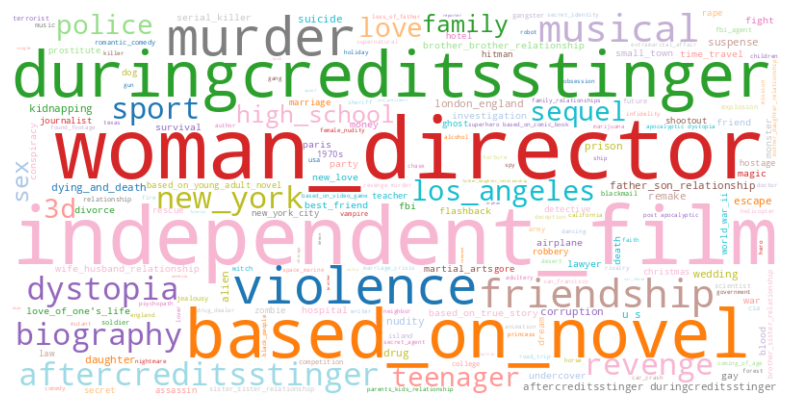

In [77]:
wordcloud = WordCloud(width = 800, height = 400, background_color ='white', colormap='tab20').generate(keywords_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

We do not proced with this because some of them seem a bit weird and it is not very standard.

#### Correlations

Quick overall view at the correlations of the numerical data

In [8]:
# removing the id because it does not make sense to use it here eventhough it is a numerical column
df_no_id = df.copy()
df_no_id.drop('id', axis=1, inplace=True)

<ipython-input-9-f140a84f2851>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_no_id.corr(), cmap='icefire_r', center=0, annot=True, vmin=0, vmax=1)


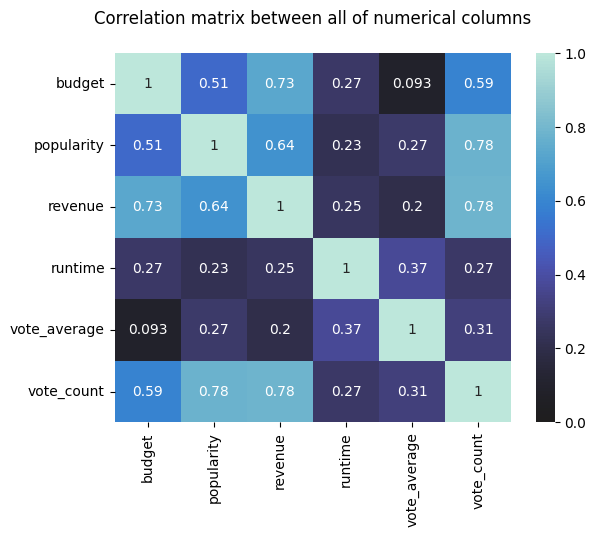

In [9]:
plt.title('Correlation matrix between all of numerical columns\n')
sns.heatmap(df_no_id.corr(), cmap='icefire_r', center=0, annot=True, vmin=0, vmax=1)
plt.show()

We see correlation between budget, popularity, revenue and vote_count. **All** positive correlations, which make sense.

**It is interesting to see how vote_average does not correlate with anything, not popularity, not revenue, nor budget, as we could have expected. Not even vote_count**

Now, to see the correlations a bit better and account visually for the spread:

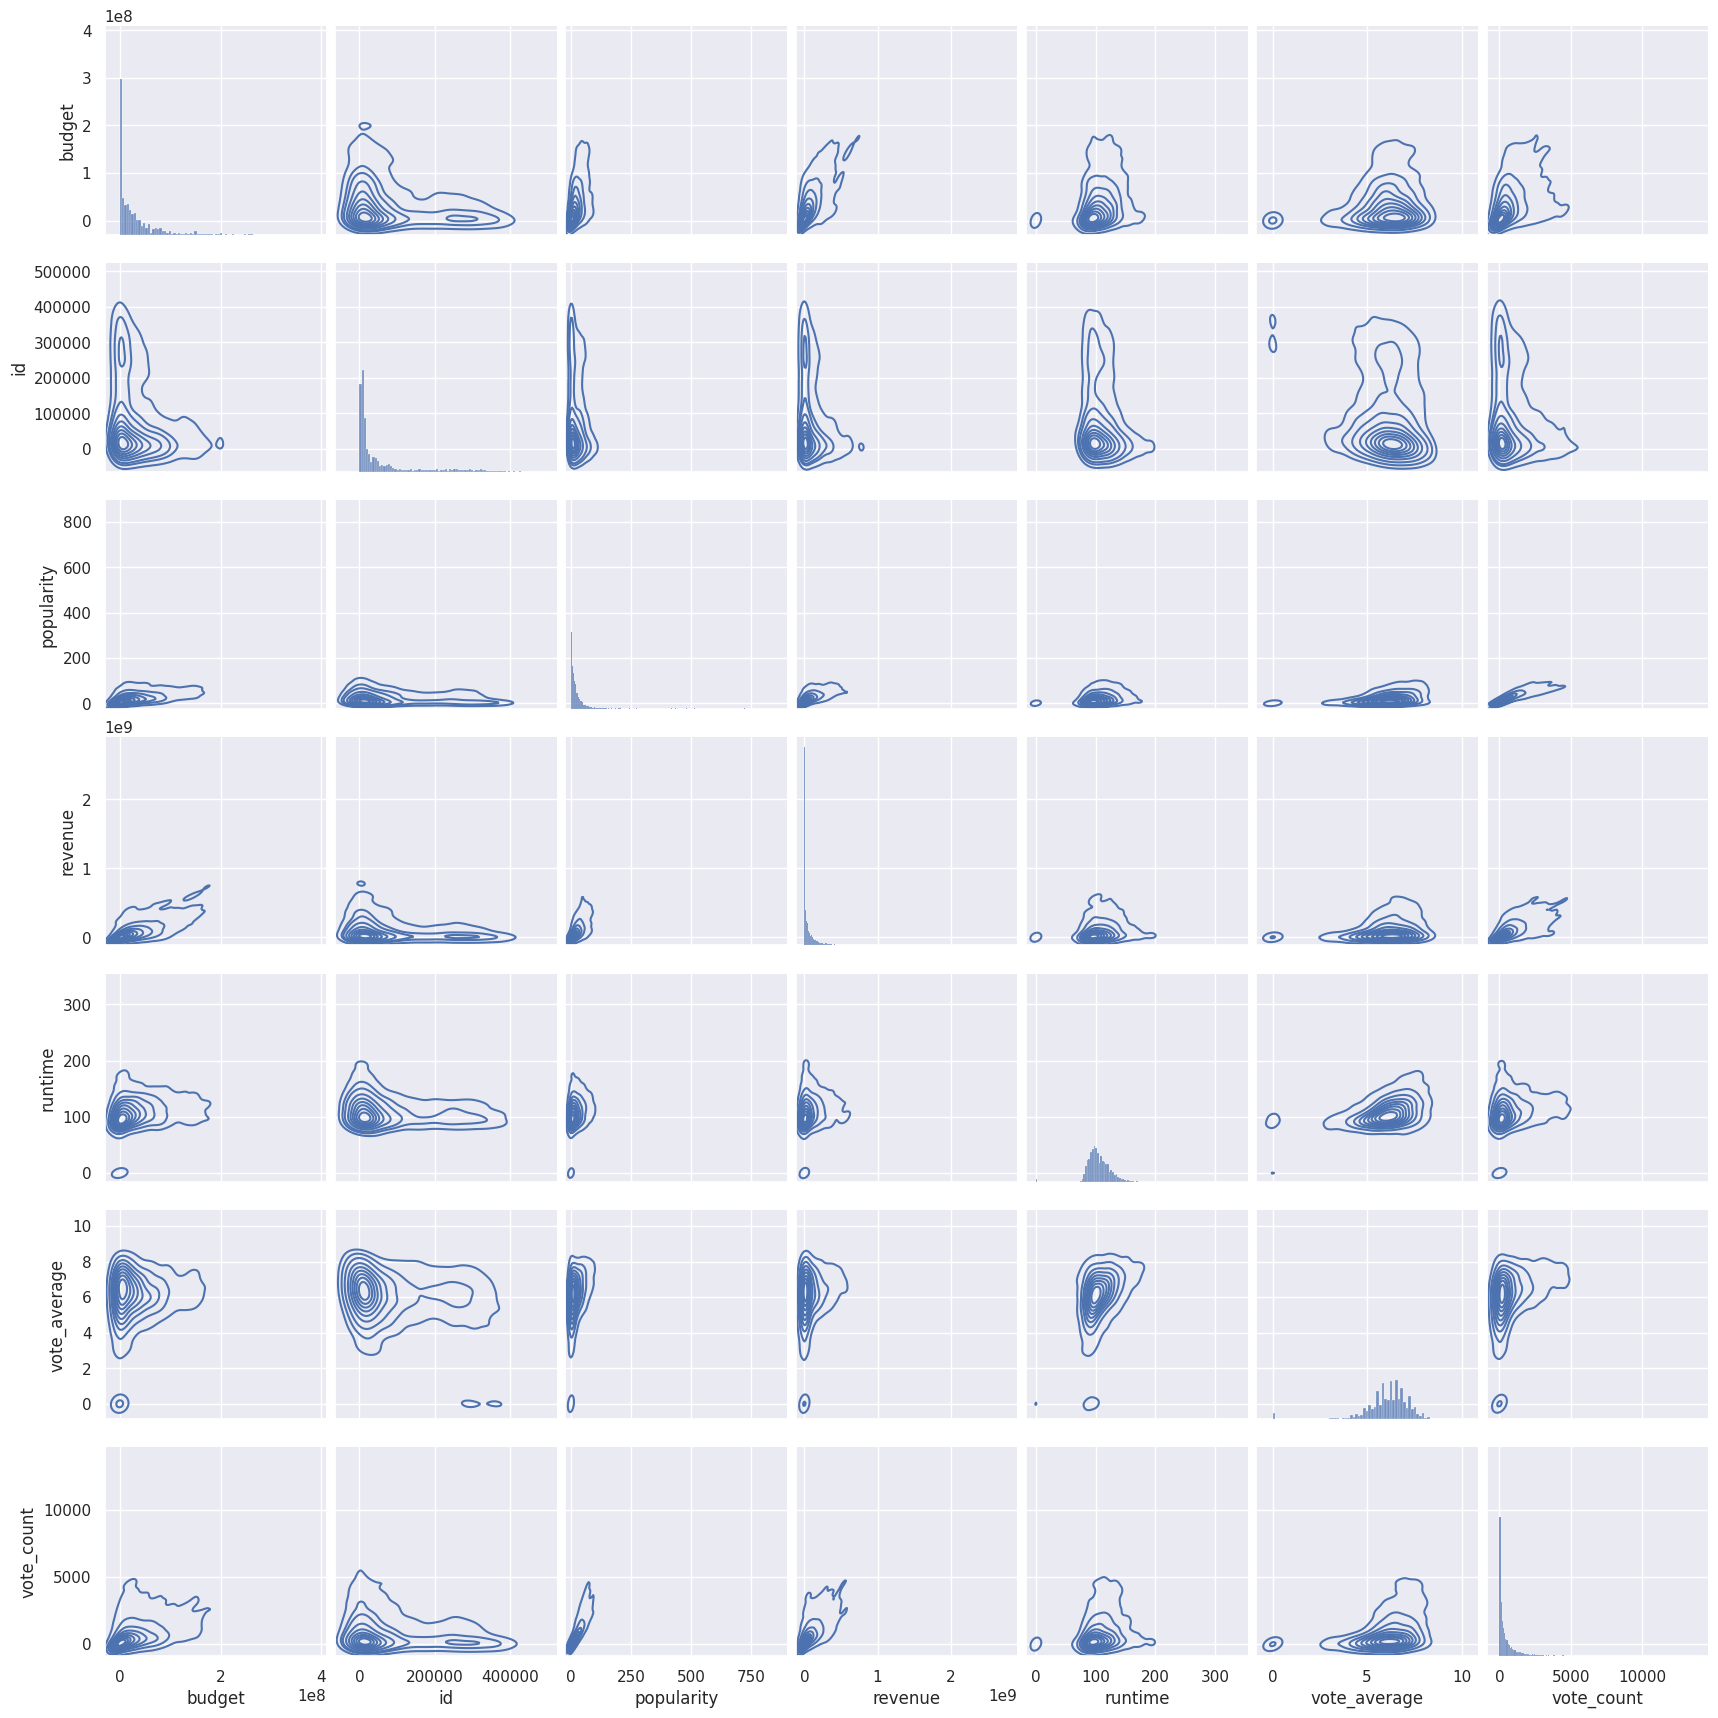

In [10]:
sns.set_theme(style="darkgrid")
sns.pairplot(df,kind="kde", diag_kind="hist")
plt.show()

#### Vicennials

We divided the data in vicennials (two decades) to analyse the differences in correlation with time

We compute the profit assuming budget = cost, which is fairly accurate in the film industry.

In [11]:
df['profit'] = df['revenue'] - df['budget']

In [12]:
# Creation of vicennial buckets
vicennials = ['1916-01-01', '1940-01-01', '1960-01-01', '1980-01-01', '2000-01-01', '2020-01-01']  # Dates as strings
vicennials_name = ['1916-1940', '1940-1960', '1960-1980', '1980-2000', '2000-2020']  # Category names

# Convert vicenials to datetime
vicennials = pd.to_datetime(vicennials)

df['vicennials'] = pd.cut(df['release_date'],
                         bins=vicennials,
                         labels=vicennials_name,
                         include_lowest=True)

In [13]:
df.sort_values('release_date', inplace=True); # to make sure the line graph shows correctly

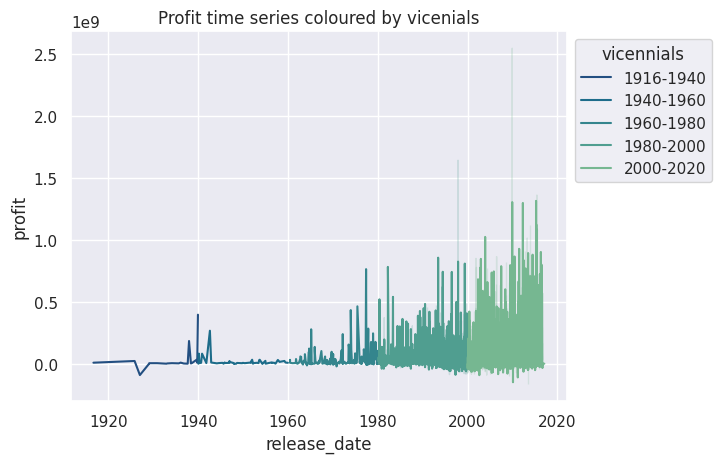

In [14]:
plt.title('Profit time series coloured by vicenials')
ax = sns.lineplot(data = df, x = 'release_date', y = 'profit', hue='vicennials', palette='crest_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

Now we group the dataframe according to the vicennials to then get the correlation between Revenue and Budget, and Revenue and Popularity

In [15]:
df_grouped_vic = df.groupby('vicennials')[['budget', 'revenue', 'profit']].median().copy()

In [16]:
# Correlation Between Revenue and Budget Across Vicennials
correlations = df.groupby('vicennials').apply(lambda g: g['revenue'].corr(g['budget']))
correlations = correlations.reset_index(name='correlation')

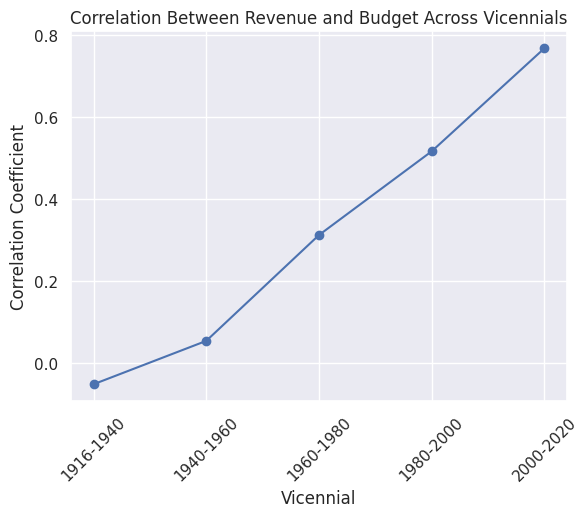

In [17]:
plt.plot(correlations['vicennials'], correlations['correlation'], marker='o')
plt.title('Correlation Between Revenue and Budget Across Vicennials')
plt.xlabel('Vicennial')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [18]:
# Correlation Between Popularity and Budget Across Vicennials
correlations2 = df.groupby('vicennials').apply(lambda g: g['popularity'].corr(g['budget']))
correlations2 = correlations2.reset_index(name='correlation')

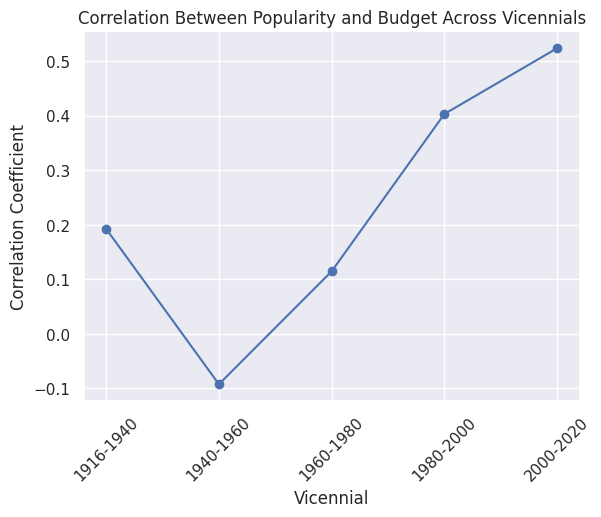

In [19]:
plt.plot(correlations2['vicennials'], correlations2['correlation'], marker='o')
plt.title('Correlation Between Popularity and Budget Across Vicennials')
plt.xlabel('Vicennial')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**KEY POINT 1:
We could think that with the rise of social media films with less budget could reach high popularity. However it looks like we are more influenced than ever by high budgets because budget and popularity are more correlated**

It would be interesting to look at the spread as well as we expect that in recent times there might be more spread accounting for the effects of social media.

#### Explode Genres

We want to look at our data using the genres. For that we expand (explode) the dataframe creating as many new duplicate rows for each film as genres it is categorised in.

In [20]:
# Explode the 'genres' column
df_exploded = df.explode('genres')
df_exploded = df_exploded.reset_index(drop=True)
df_exploded.sort_values('release_date', inplace=True);

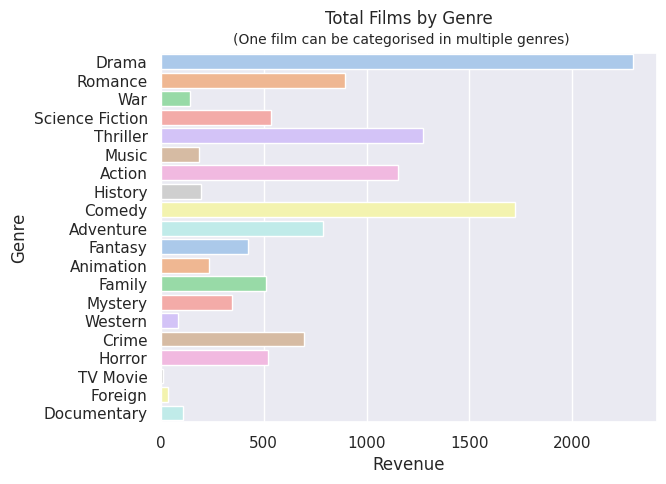

In [21]:
sns.countplot(y='genres', data=df_exploded, hue='genres', legend=False, palette='pastel')

plt.title('Total Films by Genre\n')
plt.text(0.5, 0.89, '(One film can be categorised in multiple genres)\n', fontsize=10, ha='center', va='center', transform=plt.gcf().transFigure)

plt.xlabel('Revenue')
plt.ylabel('Genre')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

The ammount of films in each Genre varies a lot so we need to keep this in mind going forward

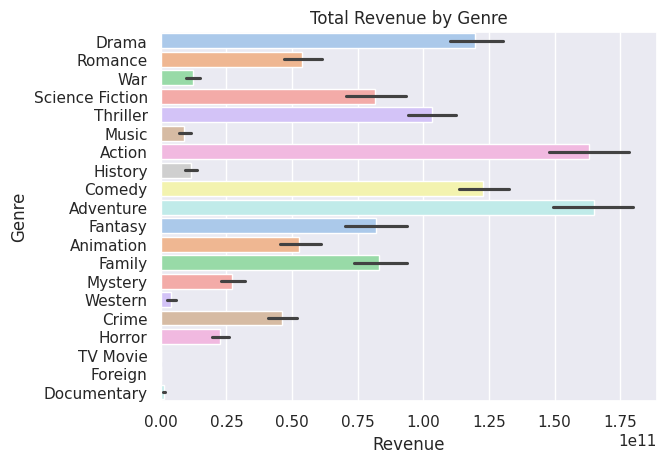

In [22]:
# EXTRA
sns.barplot(x='revenue', y='genres', data=df_exploded, estimator=sum, hue='genres', legend=False, palette='pastel')

plt.title('Total Revenue by Genre')
plt.xlabel('Revenue')
plt.ylabel('Genre')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

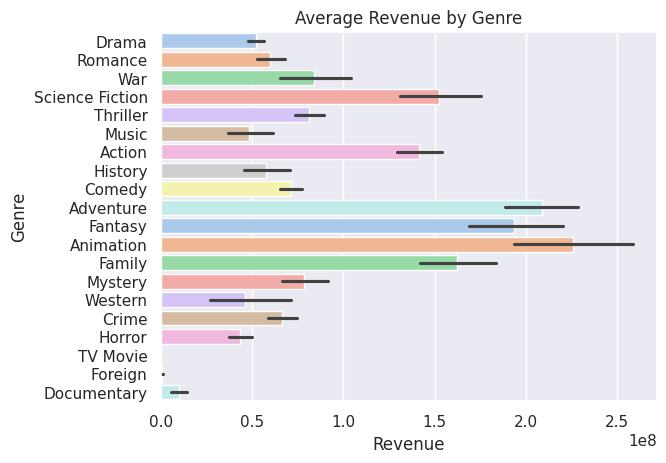

In [23]:
# EXTRA
sns.barplot(x='revenue', y='genres', data=df_exploded, estimator=np.mean, hue='genres', legend=False, palette='pastel')

plt.title('Average Revenue by Genre')
plt.xlabel('Revenue')
plt.ylabel('Genre')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

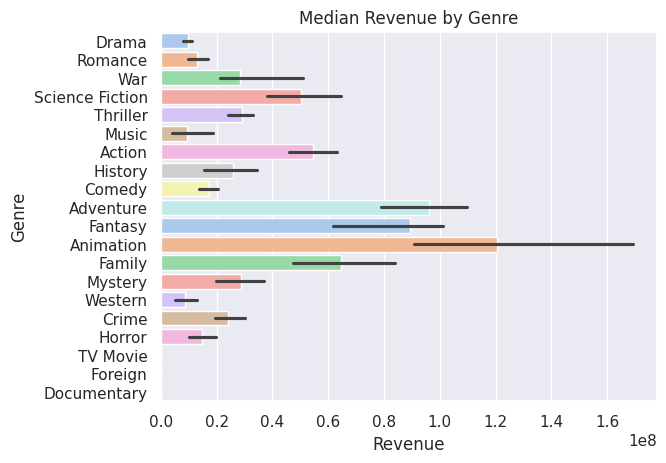

In [24]:
# EXTRA

sns.barplot(x='revenue', y='genres', data=df_exploded, estimator=np.median, hue='genres', legend=False, palette='pastel')

plt.title('Median Revenue by Genre')
plt.xlabel('Revenue')
plt.ylabel('Genre')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()

<ipython-input-25-33bf5573b5ec>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='revenue', y='genres', data=df_exploded, palette='pastel')


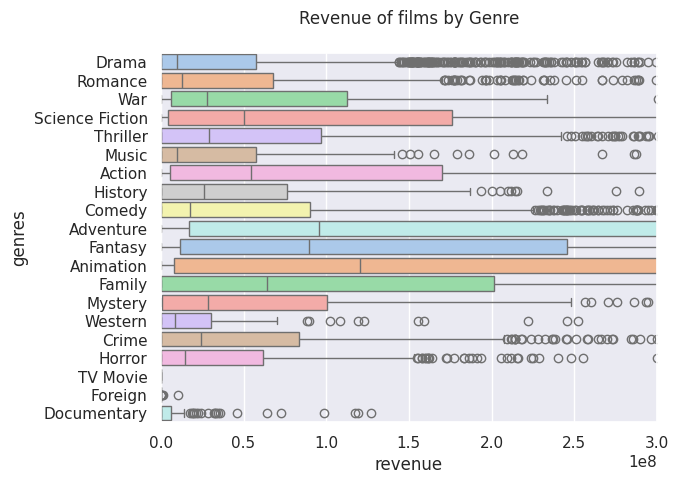

In [25]:
# EXTRA

plt.title('Revenue of films by Genre\n')
sns.boxplot(x='revenue', y='genres', data=df_exploded, palette='pastel')
plt.xlim(0, 3e+08)
plt.show()

Because there is a lot of outliers it might be more accurate to look at medians rather than means when comparing.

In [26]:
# Now compute the correlations
correlations_by_genre = (df_exploded
                         .groupby(['vicennials', 'genres'])
                         .apply(lambda g: g['popularity'].corr(g['budget']))
                         .reset_index(name='correlation'))

correlations_by_genre.dropna(axis = 0, how = 'any', subset = ['correlation',], inplace = True)


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


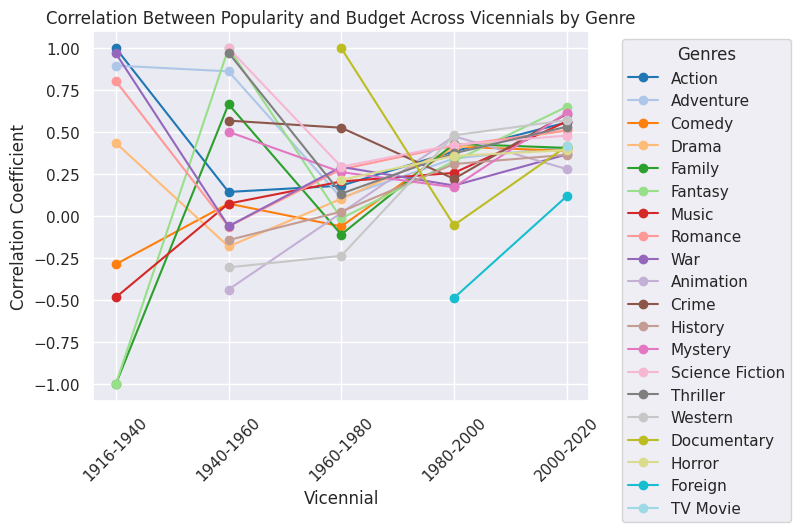

In [30]:
sns.set_palette('tab20')

for genre in correlations_by_genre.genres.unique():
    genre_data = correlations_by_genre[correlations_by_genre['genres'] == genre]
    plt.plot(genre_data['vicennials'], genre_data['correlation'], marker='o', label=genre)

plt.title('Correlation Between Popularity and Budget Across Vicennials by Genre')
plt.xlabel('Vicennial')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**KEYPOINT: Different genres showed a lot of variability in how bugget was converted into popularity but as time goes by, we see similar conversions regardless of genre.** In a way it shows by vicenial how well of a predictor of success was the budget.


Bedore the 60s, Adventure, Action, War, Romance had remarkable positive correlations. Whereas Fantasy, Family, Comedy or Music showed negative correlations. We should also consider that the more back in time the less data we have, so that might explain such strong correlations. After 1980 all show positive correlations, but not as strong as before the 60s

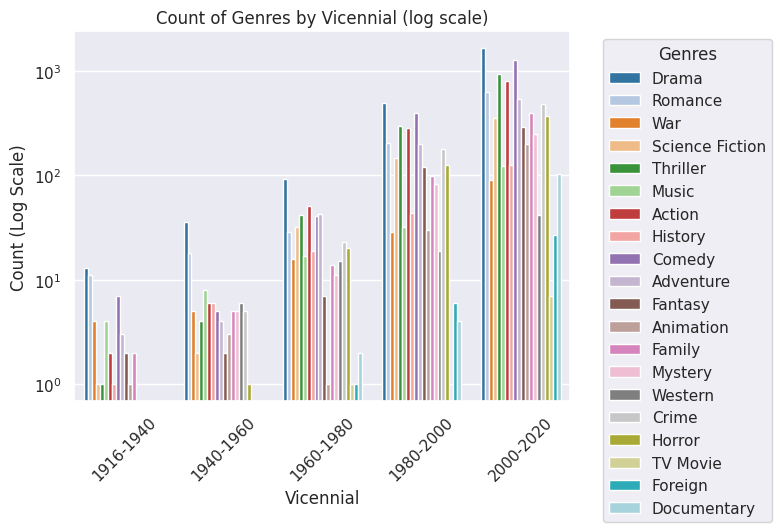

In [40]:
ax = sns.countplot(data=df_exploded, x='vicennials', hue='genres')
plt.title('Count of Genres by Vicennial (log scale)')
plt.xlabel('Vicennial')
plt.ylabel('Count (Log Scale)')
plt.xticks(rotation=45)
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_yscale('log') # to see better the small values
plt.show()


# KEYPOINTS

**1) We could think that with the rise of social media films with less budget could reach high popularity. However it looks like we are more influenced than ever by high budgets.**

**2) Different genres showed a lot of variability in how bugget was converted into popularity but as time goes by, we see similar conversions regardless of genre.** In a way it shows by vicenial how well of a predictor of success was the budget.


Bedore the 60s, Adventure, Action, War, Romance had remarkable positive correlations. Whereas Fantasy, Family, Comedy or Music showed negative correlations. After 1980 all show positive correlations, but not some of them not as strong as before the 60s

# TWO MOVIES IN DETAIL

**Max popularity:**

## MINIONS

In [32]:
df[df.popularity==df.popularity.max()].values

array([[74000000, list(['Family', 'Animation', 'Adventure', 'Comedy']),
        'http://www.minionsmovie.com/', 211672,
        list(['assistant', 'aftercreditsstinger', 'duringcreditsstinger', 'evil mastermind', 'minions', '3d']),
        'en', 'Minions',
        'Minions Stuart, Kevin and Bob are recruited by Scarlet Overkill, a super-villain who, alongside her inventor husband Herb, hatches a plot to take over the world.',
        875.581305,
        list(['Universal Pictures', 'Illumination Entertainment']),
        list(['United States of America']),
        Timestamp('2015-06-17 00:00:00'), 1156730962, 91.0, list(['en']),
        'Released', 'Before Gru, they had a history of bad bosses',
        'Minions', 6.4, 4571, 1082730962, '2000-2020']], dtype=object)

**Max revenue:**

## AVATAR

In [33]:
df[df.revenue==df.revenue.max()].values

array([[237000000,
        list(['Action', 'Adventure', 'Fantasy', 'Science Fiction']),
        'http://www.avatarmovie.com/', 19995,
        list(['culture clash', 'future', 'space war', 'space colony', 'society', 'space travel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alien planet', 'cgi', 'marine', 'soldier', 'battle', 'love affair', 'anti war', 'power relations', 'mind and soul', '3d']),
        'en', 'Avatar',
        'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.',
        150.437577,
        list(['Ingenious Film Partners', 'Twentieth Century Fox Film Corporation', 'Dune Entertainment', 'Lightstorm Entertainment']),
        list(['United States of America', 'United Kingdom']),
        Timestamp('2009-12-10 00:00:00'), 2787965087, 162.0,
        list(['en', 'es']), 'Released', 'Enter the World of Pandora.',
        'Avatar', 7.2, 11800, 25

Genres intersection:

In [34]:
set(list(df[df.revenue==df.revenue.max()].genres)[0]).intersection(set(list(df[df.popularity==df.popularity.max()].genres)[0]))

{'Adventure'}

Both are **Adventure**, wich is one of the all time profitable genres with good average and median values, although a large distribution. And the genre with biggest total revenue.

Keywords intersection:

In [35]:
set(list(df[df.revenue==df.revenue.max()].keywords)[0]).intersection(set(list(df[df.popularity==df.popularity.max()].keywords)[0]))

{'3d'}

We can also see they are **3D** with make sense given their big budgets and popularity.

Lets look at 3d:

In [60]:
filtered_df = df[df['keywords'].apply(lambda x: '3d' in x)]

In [62]:
filtered_df2 = filtered_df.copy()
filtered_df2.drop(filtered_df2[filtered_df2.revenue==filtered_df2.revenue.max()].index, inplace=True)
filtered_df2.drop(filtered_df2[filtered_df2.popularity==filtered_df2.popularity.max()].index, inplace=True)

<ipython-input-68-de7e8e554334>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(filtered_df[df.revenue==df.revenue.max()].popularity, filtered_df[df.revenue==df.revenue.max()].revenue, color='teal', marker='$A$', s=150, label='Avatar')
<ipython-input-68-de7e8e554334>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(filtered_df[df.popularity==df.popularity.max()].popularity, filtered_df[df.popularity==df.popularity.max()].revenue, color='teal', marker='$M$', s=150, label='Minions')


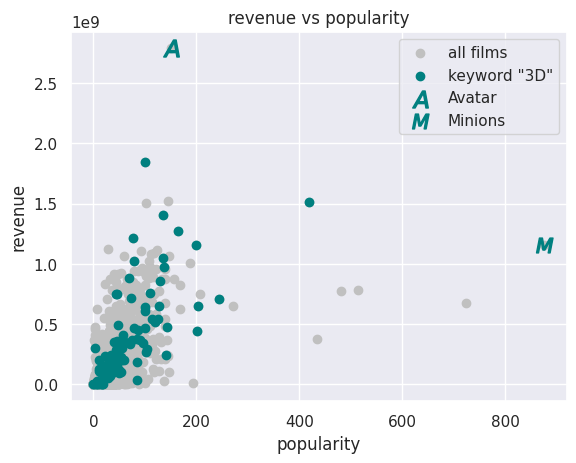

In [68]:
plt.title('revenue vs popularity')
plt.scatter(df.popularity, df.revenue, color='silver', label='all films')
plt.scatter(filtered_df2.popularity, filtered_df2.revenue, color='teal', label='keyword "3D"')
plt.scatter(filtered_df[df.revenue==df.revenue.max()].popularity, filtered_df[df.revenue==df.revenue.max()].revenue, color='teal', marker='$A$', s=150, label='Avatar')
plt.scatter(filtered_df[df.popularity==df.popularity.max()].popularity, filtered_df[df.popularity==df.popularity.max()].revenue, color='teal', marker='$M$', s=150, label='Minions')
plt.xlabel('popularity')
plt.ylabel('revenue')
plt.legend()
plt.show()